In [1]:

import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math

from tqdm import tqdm_notebook
from collections import Counter
from glob import glob
from unidecode import unidecode
from nltk.corpus import stopwords
from datetime import datetime

import utils

%matplotlib inline

sns.set(style="darkgrid")

In [2]:
PATH = '../'

PROCESSED_DATA_PATH = os.path.join(PATH, 'data/processed/')

DF_PRIME_TRUNCATED_PATH = os.path.join(PROCESSED_DATA_PATH, 'df_prime_truncated.pkl')
DF_USP_TRUNCATED_PATH = os.path.join(PROCESSED_DATA_PATH, 'df_usp_truncated_clean.pkl')


STOPWORDS = utils.get_stopwords()

In [3]:
df_fakebr = pkl.load(open(DF_USP_TRUNCATED_PATH, 'rb'))

In [4]:
from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.calibration import CalibratedClassifierCV

from sklearn.pipeline import Pipeline

In [5]:
PATH = '../'

PROCESSED_DATA_PATH = os.path.join(PATH, 'data/processed/')

DF_PRIME_TRUNCATED_PATH = os.path.join(PROCESSED_DATA_PATH, 'df_prime_truncated.pkl')
DF_USP_TRUNCATED_PATH = os.path.join(PROCESSED_DATA_PATH, 'df_usp_truncated_clean.pkl')


STOPWORDS = utils.get_stopwords()

df_prime = pkl.load(open(DF_PRIME_TRUNCATED_PATH, 'rb'))

df_fakebr = pkl.load(open(DF_USP_TRUNCATED_PATH, 'rb'))

In [6]:
X_train_prime, X_test_prime, y_train_prime, y_test_prime = \
    train_test_split(df_prime['TEXT_CLEAN'], df_prime['FAKE'], test_size=0.3, random_state=42)

In [7]:
X_train_fakebr, X_test_fakebr, y_train_fakebr, y_test_fakebr = \
    train_test_split(df_fakebr['TEXT_CLEAN'], df_fakebr['FAKE'], test_size=0.3, random_state=42)

In [8]:
X_train_all = list(X_train_fakebr) + list(X_train_prime)
y_train_all = list(y_train_fakebr) + list(y_train_prime)

In [9]:
X_aux = list(X_test_fakebr) + list(X_test_prime)
y_aux = list(y_test_fakebr) + list(y_test_prime)
src_aux = len(list(y_test_fakebr)) * ['fakebr'] + len(list(y_test_prime)) * ['prime']

df_resample = pd.DataFrame({'X': X_aux, 'y': y_aux, 'src': src_aux})
rus = RandomUnderSampler()
resampled = rus.fit_resample(df_resample[['X', 'y']], df_resample['src'])

X_test_all = [item[0] for item in resampled[0]]
y_test_all = [item[1] for item in resampled[0]]

In [10]:
vectorizer_list = [
    TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9, max_features=10000)
]


pipe = Pipeline([('vect', vectorizer_list[0]), ('clf', LogisticRegression())])

param_grid = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'clf__solver': ['lbfgs', 'saga'],
    'clf__tol': [1e-5, 1e-4, 1e-3, 1e-2]
}

In [11]:
gscv = GridSearchCV(pipe, param_grid, cv=5, n_jobs=4, verbose=10)
gscv.fit(X_train_fakebr, y_train_fakebr)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    7.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   14.7s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   18.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   25.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   30.5s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   37.3s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   43.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   53.4s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  1.9min
[Parallel(

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.9,
                                                        max_features=10000,
                                                        min_df=5,
                                                        ngram_range=(1, 2),
                                         

In [12]:
print("Best parameter (CV score={:.3f}):".format(gscv.best_score_))
print(gscv.best_params_)


Best parameter (CV score=0.902):
{'clf__C': 1000, 'clf__solver': 'lbfgs', 'clf__tol': 0.001}


In [13]:
clf_kwargs = {'C': 100, 'solver': 'saga', 'tol': 0.0001}

pipe = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9, max_features=10000)), 
    ('clf', LogisticRegression(**clf_kwargs))
])


In [14]:
pipe.fit(X_train_fakebr, y_train_fakebr)

D:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.9, max_features=10000,
                                 min_df=5, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=100, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling

In [15]:
y_pred = pipe.predict(X_test_all)

In [16]:
print(classification_report(y_test_all, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       358
           1       0.87      0.86      0.87       380

    accuracy                           0.86       738
   macro avg       0.86      0.86      0.86       738
weighted avg       0.86      0.86      0.86       738



In [17]:
print(confusion_matrix(y_test_all, y_pred))

[[311  47]
 [ 53 327]]


In [18]:
accuracy_score(y_test_all, y_pred)

0.8644986449864499

In [54]:
def proba_thresh(pipe, X_test, y_test, threshold):

    y_proba = pipe.predict_proba(X_test)
    y_pred_proba = []
    y_test_proba = []


    for i, proba in enumerate(y_proba):
        if proba.max() > threshold:
            y_pred_proba.append(y_pred[i])
            y_test_proba.append(y_test[i])

    coverage = len(y_test_proba) / len(y_test)
    
    return (y_test_proba, y_pred_proba, coverage)

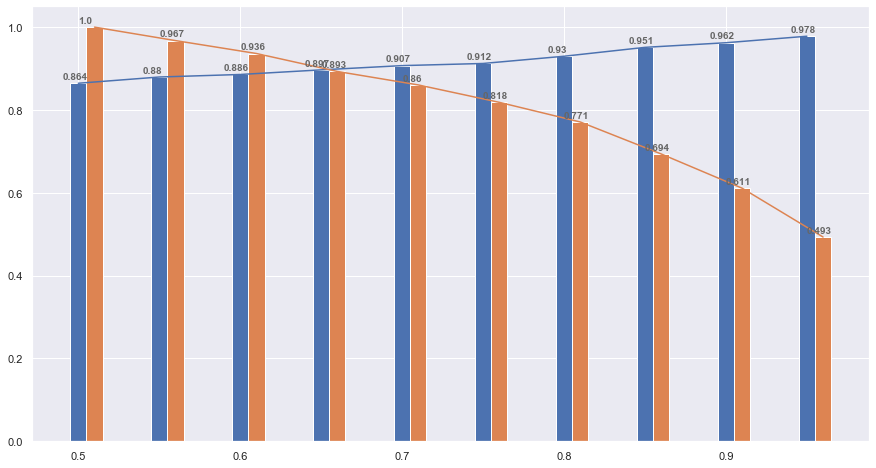

In [100]:
accuracy = []
coverage = []

img, ax = plt.subplots(figsize=(15, 8))


for i in np.arange(0.5, 1, 0.05):
    x = round(i, 2)
    
    y_test_aux, y_pred_aux, cover = proba_thresh(pipe, X_test_all, y_test_all, x)
    accuracy_aux = accuracy_score(y_test_aux, y_pred_aux)
    accuracy.append(accuracy_aux)
    coverage.append(cover)
    plt.text(x - 0.01, accuracy_aux + 0.01, round(accuracy_aux, 3), color="#666666", fontweight="bold")
    plt.text(x, cover + 0.01, round(cover, 3), color="#666666", fontweight="bold")
    
    
plt.bar(np.arange(0.5, 1, 0.05), accuracy, width=0.01)
plt.plot(np.arange(0.5, 1, 0.05), accuracy)
plt.bar(np.arange(0.5, 1, 0.05) + 0.01, coverage, width=0.01)
plt.plot(np.arange(0.5, 1, 0.05) + 0.01, coverage)

In [42]:
print(classification_report(y_test_proba, y_pred_proba)), coverage

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       217
           1       0.97      0.96      0.96       234

    accuracy                           0.96       451
   macro avg       0.96      0.96      0.96       451
weighted avg       0.96      0.96      0.96       451



(None, 0.6111111111111112)

In [102]:
with open('../data/processed/pipeline.pkl', 'wb') as f:
    pkl.dump(pipe, f)

In [ ]:
# explicitar que para fins de treinamento os conjuntos seriam utilizados separadamente durante todo o trabalho